#<b>AlexNet Experiment <b>

In this experiment we use AlexNet as the base architecture for demonstrating the style transfer task. Our aim for choosing AlexNet is to show that the overall foundation of style and content extraction is general and works even with different base architectures

In [0]:

import torchvision.models as models
from torch.autograd import Variable
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
imsize = 512 
is_cuda = torch.cuda.is_available()

prep = transforms.Compose([transforms.Resize(imsize),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [0]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(prep(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We display the image to which the style would be transfered

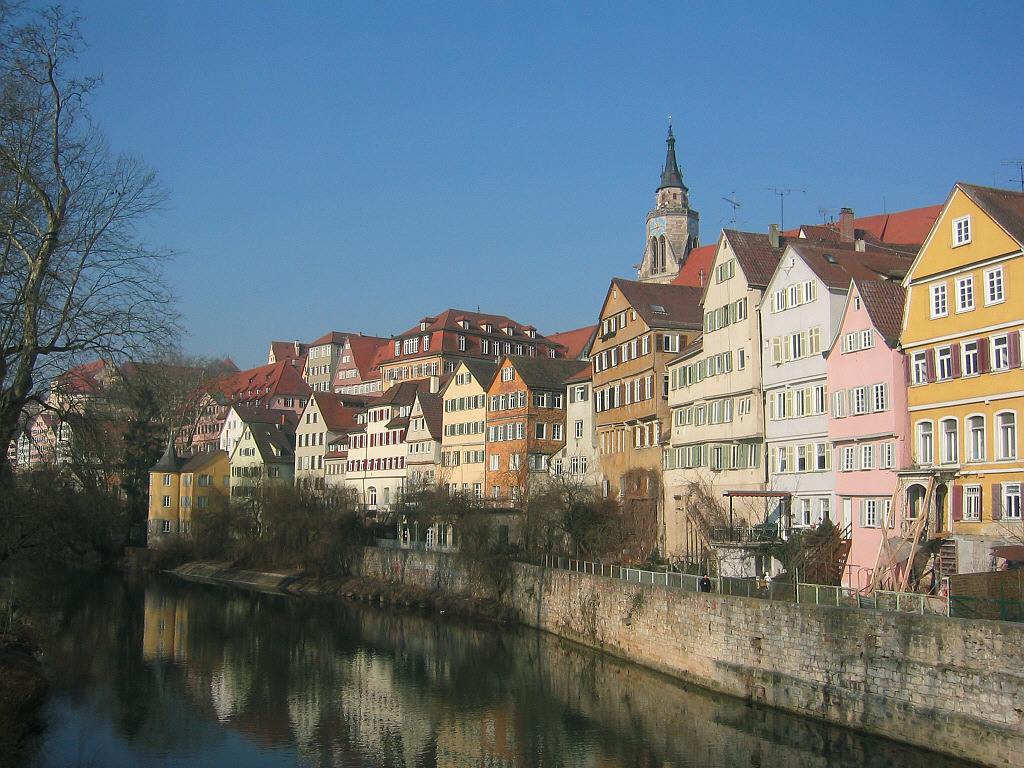

In [0]:
Image.open('/content/drive/My Drive/Paint.io/Images/Tuebingen_Neckarfront.jpg')

We import both the style and the content image just like we did in the VGG16 case. \
We also load the AlexNet acheitecture with pre-trained weights.

In [0]:
style_img = image_loader("/content/drive/My Drive/Paint.io/Images/vangogh_starry_night.jpg")
content_img = image_loader("/content/drive/My Drive/Paint.io/Images/Tuebingen_Neckarfront.jpg")
net = models.alexnet(pretrained=True).features
for param in net.parameters():
    param.requires_grad = False
if is_cuda:
    style_img = style_img.cuda()
    content_img = content_img.cuda()
    net = net.cuda()

opt_img = Variable(content_img.data.clone(),requires_grad=True)

Now, we extract the indexes of all Conv2D layers and store it in an array. This would facilitate easy extraction of hidden features from the desired layer.

In [0]:
i=0
index=[]
for layer in net.children():
    if isinstance(layer, nn.Conv2d):
      index.append(i)
    i=i+1

We choose first 3 Conv2D layers for extracting the style and last Conv2D layers for extracting the content

In [0]:
style_layers = [index[i] for i in range(0,3) ]
content_layers = [index[-1]]
loss_layers = style_layers + content_layers

In [0]:
class LayerActivations():
    features=[]
    
    def __init__(self,model,layer_nums):
        
        self.hooks = []
        for layer_num in layer_nums:
            self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))
    
    def hook_fn(self,module,input,output):
        self.features.append(output)

    
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [0]:
class GramMatrix(nn.Module):
    
    def forward(self,input):
        b,c,h,w = input.size()
        features = input.view(b,c,h*w)
        gram_matrix =  torch.bmm(features,features.transpose(1,2))
        gram_matrix.div_(h*w)
        return gram_matrix
        
class StyleLoss(nn.Module):
    
    def forward(self,inputs,targets):
        out = nn.MSELoss()(GramMatrix()(inputs),targets)
        return (out)

In [0]:
def extract_layers(layers,img,model=None):
    la = LayerActivations(model,layers)
    #Clearing the cache 
    la.features = []
    out = model(img)
    la.remove()
    return la.features


content_targets = extract_layers(content_layers,content_img,model=net)
content_targets = [t.detach() for t in content_targets]
style_targets = extract_layers(style_layers,style_img,model=net)
style_targets = [GramMatrix()(t).detach() for t in style_targets]
targets = style_targets + content_targets

In [0]:
loss_fns = [StyleLoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if is_cuda:
    loss_fns = [fn.cuda() for fn in loss_fns]

Similar weights as used for VGG16 experiment are used

In [0]:
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256]]
content_weights = [1e0]
weights = style_weights + content_weights

In [0]:
#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        out = extract_layers(loss_layers,opt_img,model=net)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss
    
    optimizer.step(closure)

Iteration: 50, loss: 2963.820068
Iteration: 100, loss: 876.774048
Iteration: 150, loss: 561.924988
Iteration: 200, loss: 449.464661
Iteration: 250, loss: 391.554138
Iteration: 300, loss: 355.201355
Iteration: 350, loss: 329.345551
Iteration: 400, loss: 311.826233
Iteration: 450, loss: 297.423157
Iteration: 500, loss: 286.153717


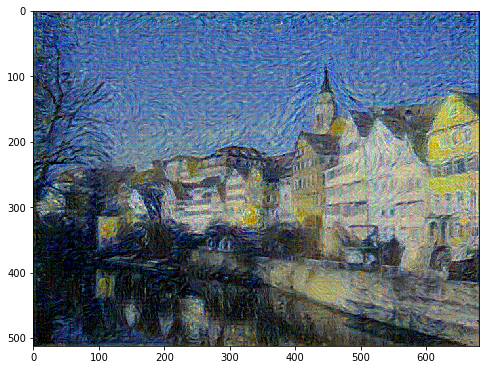

In [0]:

from PIL import Image
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(8,8)
dataset_root_dir= "/content/drive/My Drive/Paint.io/"
result_dir = dataset_root_dir + '/GatysComparisonResults/Style-Content-Output/'
out_img.save(result_dir+'AlexNet.jpg')


We see that the result obtained shows that some style has been transfered to the target image. There is presence of noise and this might attribute to the AlexNet's architecture. Also, the weights we used for weighing the style and content loss was choosen the same we used for VGG. Optimal weights for VGG are not necessary optimum for AlexNet architecture as well.

<b>The main purpose of this experiment was to show that style and content extraction is a general concept. The results mught need fine-tuning in terms of hyperparameters to improve the quality of results, but this experiment demoonstrates the universality of the concept</b>